In [2]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import urbanFormPy as up

In [3]:
#initialise path, names, etc.

city_name = 'Paris'
place = 'Paris, France'
epsg = 27581

crs = {'init': 'epsg:27581', 'no_defs': True}

### Downloading

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *OSMpolygon*, provide an OSM polygon (relation) name.
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)

In [ ]:
download_method_graph = 'OSMplace'
distance = None

In [ ]:
# nodes_graph, edges_graph = up.get_network_fromOSM(download_method_graph, place, 'walk', epsg, distance = distance)
"""
- "same_uv_edges" regulates the handling of edges with same pair of u-v nodes but different geometries.
When true keeps a center line between the two segments, unless one of the two segments is significantly longer than 
the other (>30%). In this case, the longer segment is deleted.
"""
nodes_graph, edges_graph = up.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_disconnected_islands = True,
                            self_loops = True, same_uv_edges = True)

In [ ]:
up.plot_lines(edges_graph, scheme = None,
              black_background = False, fig_size = 15, title = city_name+': Street Network')

In [ ]:
# obtaining graph from the case-study area 
graph = up.graph_fromGDF(nodes_graph, edges_graph)

In [ ]:
# Creating the dual geodataframes and the dual graph.
nodesDual_graph, edgesDual_graph = up.dual_gdf(nodes_graph, edges_graph, epsg)
dual_graph = up.dual_graph_fromGDF(nodesDual_graph, edgesDual_graph)

In [ ]:
"""
Different weights are used to extract the partitions. "None" indicates that no weights will be used 
(only topological relationships will matter). The function returns a GeoDataFrame with partitions assigned to edges,
with column named as "p_name_weight" (e.g. "p_length")
 
"""
weights = ['length', 'rad', None]
for i in weights:
    edges_graph = up.identify_regions(dual_graph, edges_graph, weight = i)

In [ ]:
# visualising
up.plot_lines(edges_graph, column = "p_no_weight", title = 'Districts', lw = 1.5, cmap = 'tab20', black_background = True, 
              legend = False, fig_size = 15)

In [ ]:
# polygonise districts

districts = edges_graph['p_rad']. 

In [2]:
# loading
loading_path = "C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/London/large_network/for_Simulation/"
edges_graph = gpd.read_file(loading_path+"London_edges.shp")
place = 'London'
method = "distance_from_adress"
distance = 4000
crs = edges_graph.crs

# Barriers

In [6]:
convex_hull = edges_graph.geometry.unary_union.convex_hull
waterways_barriers = up.waterway_barriers(place, distance, convex_hull, crs)
railways_barriers = up.railway_barriers(place, distance, convex_hull, crs)
barriers = railways_barriers.append(waterways_barriers)
barriers.reset_index(inplace = True, drop = True)
barriers['barrierID'] = barriers.index.astype(int)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

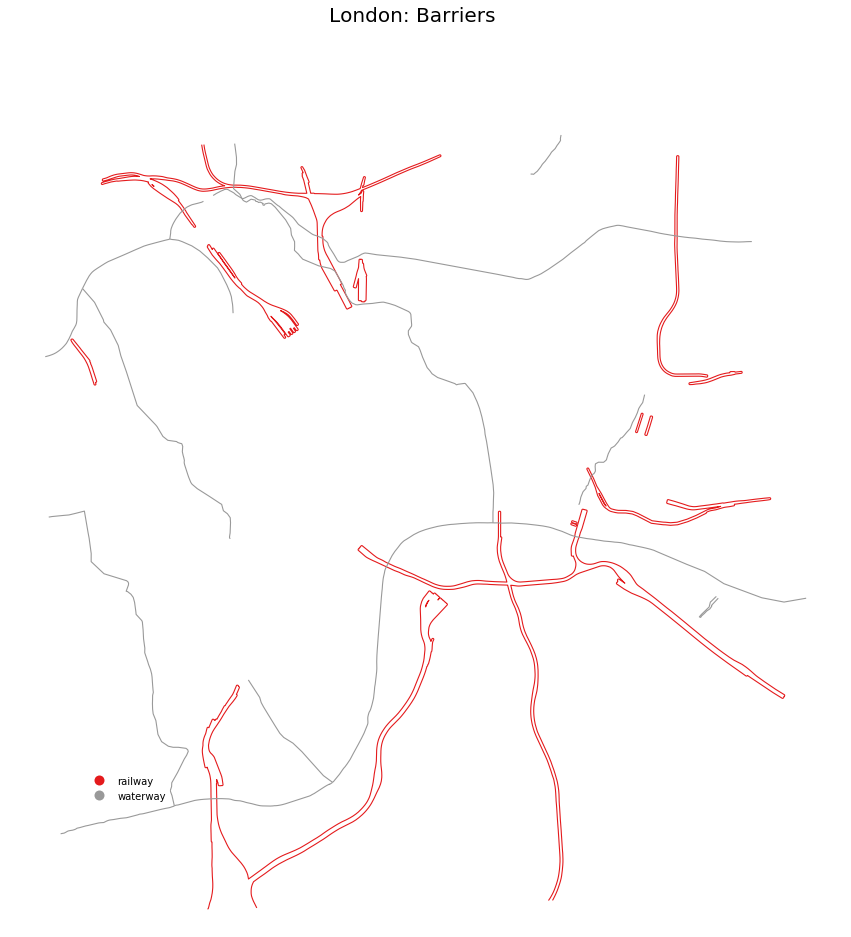

In [7]:
up.plot_lines(barriers, cmap = 'Set1', column = 'type',
              black_background = False, fig_size = 15, title = place+': Barriers', legend = True)

In [23]:
rivers_graph = ox.graph_from_place("Greater London", retain_all = True, truncate_by_edge=True, simplify=True,
                           network_type='none', infrastructure= 'way["waterway"]' )

In [30]:
rivers["tunnel"].fillna(0, inplace = True)
rivers = rivers[rivers["tunnel"] == 0]   
rivers

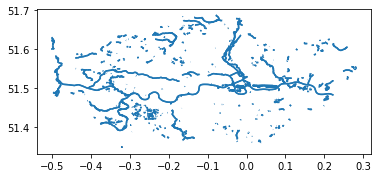

In [32]:
rivers.plot()

In [15]:
saving_path = "C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/London/large_network/for_Simulation/"
barriers.to_file(saving_path+place+"_barriers.shp", driver='ESRI Shapefile')

## Assign barriers to edges

In [ ]:
lines_at_centroids = edges[["edgeID", "u", "v", "geometry"]].copy()
lines_at_centroids["geometry"] = edges.apply(lambda row: line_at_centroid(row['geometry'],200), axis = 1)
edges['counts'] = lines_at_centroids.apply(lambda row: count_at_centroid(row['geometry'], tracks), axis = 1)

In [ ]:
def rivers_along(line_geometry, rivers_gdf, edges_gdf):
    
    rivers_along = []
    intersecting_rivers = rivers_gdf[rivers_gdf.geometry.intersects(line_geometry)]
    if len(intersecting_rivers) == 0: return rivers_along
    
    else:
        for barrier in itersecting_rivers.geometry:
            # centroid of the street segment, in a nutshell, as the line_geometry it is built on the centroid
            centroid = line_geometry.centroid
            line = LineString([centroid, nearest_points(centroid, barrier)[1]])
            if len(edges_gdf[edges_gdf.geometry.intersects(line)])> 0: continue
            else: rivers_along.append(barrier)
    return rivers_along

def next_to_barriers(line_geometry, barriers_gdf):
    
    adjacent_barriers = []
    intersecting_barriers = barriers_gdf[barriers_gdf.geometry.intersects(line_geometry)]
    if len(intersecting_rivers) == 0: return adjacent_barriers
    
    adjacent_barriers = list(barriers_gdf.barrierID)
    return adjacent_barriers
    
    
    

## Assign district to nodes and edges

In [ ]:
nodes_graph['district'] = 0
index_geo = nodes.columns.get_loc("geometry")+1  
spatial_index = edges.sindex # spatial index

for row in nodes.itertuples():
    point = row[index_geo]
    n = point.buffer(20)
    possible_matches_index = list(spatial_index.intersection(n.bounds))
    pm = edges.iloc[possible_matches_index].copy()
    dist = uf.dist_to_gdf(point, pm)
    
    district = edges.loc[dist[1]]['district'] 
    nodes.at[row[0], 'district'] = district
nodes['district'] = nodes.district.astype(int)

In [ ]:
edges['district'] = 0
index_u = edges.columns.get_loc("u")+1  
index_v = edges.columns.get_loc("v")+1  
# index_district = edges.columns.get_loc("district")+1  

for i in edges.itertuples():
    district_u = nodes.loc[i[index_u]].district
    district_v = nodes.loc[i[index_v]].district
#     if district_u == district_v: 
    edges.set_value(i[0], 'district', district_u) # then you may want to correct that manually

In [ ]:
nodes.to_file(IoC_output+'_nodes.shp', driver='ESRI Shapefile')
edges.to_file(IoC_output+'_paths.shp', driver='ESRI Shapefile')

In [ ]:

fig, ax = plt.subplots(1, figsize=(15,15))
plt.axis('equal')
ax.set_axis_off()
districts_polygonized.plot(ax = ax, column = 'district', cmap = 'Set2', alpha = 0.6)